In [1]:
import os
import csv
import sys
import time
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
# These are determined in the Compare notebook by looking at the validation data
max_f1_thresholds = {
    'ref0': (1.73684511333704, 0.7828877005347594),
    'ref1': (2.1926324367523193, 0.7767903815995818),
    'ref2': (0.0, 0.6347046087225487),
    'ref3': (0.0, 0.6347046087225487),
    'ref4': (0.0, 0.6347046087225487)
}

In [3]:
resultspath = '../results/final-bydrug-output-part1_app0_ref0_222_24_25_1e-06.csv.gz'
refset = resultspath.split('_')[2]
np_random_seed = int(resultspath.split('_')[3])
random_state = int(resultspath.split('_')[4])
EPOCHS = int(resultspath.split('_')[5])
LR = resultspath.split('_')[6].split('.')[0]
threshold = max_f1_thresholds[refset][0]

print(f" refset: {refset}")
print(f" np_random_seed: {np_random_seed}")
print(f" random_state: {random_state}")
print(f" EPOCHS: {EPOCHS}")
print(f" LR: {LR}")
print(f" threshold: {threshold}")

res = pd.read_csv(resultspath, header=None)

print(f" res.shape: {res.shape}")
res.head()

 refset: ref0
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 threshold: 1.73684511333704
 res.shape: (6286475, 2)


,0,1
0,5.913762,0.000000
1,7.485912,0.000000
2,7.101522,0.000000
3,1.961310,2.357398
4,6.181447,0.000000


In [4]:
# datapath = f'../data/ref{refset}_clinical_bert_reference_set.txt'
datapath = '../data/output-part1_app0_clinical_bert_application_set.txt.gz'
df = pd.read_csv(datapath)
df.shape

(6286475, 4)

In [5]:
df = pd.concat([df, res], axis=1)
df.head()

,drug,llt_id,llt,string,0,1
0,d5f54d14-8ce7-4301-8f5d-2cb40af79a8a,1200067,discharge,discharge pneumonitis deaths have been reporte...,5.913762,0.000000
1,d5f54d14-8ce7-4301-8f5d-2cb40af79a8a,1200067,discharge,"discharge (wbc less than 3000/mm 3 ), pancytop...",7.485912,0.000000
2,d5f54d14-8ce7-4301-8f5d-2cb40af79a8a,1200350,ulceration,ulceration reported adverse effects are malais...,7.101522,0.000000
3,d5f54d14-8ce7-4301-8f5d-2cb40af79a8a,1200350,ulceration,ulceration simplex . musculoskeletal system - ...,1.961310,2.357398
4,d5f54d14-8ce7-4301-8f5d-2cb40af79a8a,1334648,red vision,"red vision bleeding, enteritis, pancreatitis. ...",6.181447,0.000000


In [6]:
%time df_grouped = df.groupby(by=['drug', 'llt']).mean().reset_index()

CPU times: user 1.82 s, sys: 248 ms, total: 2.07 s
Wall time: 2.07 s


In [7]:
times = [(1e2, 6.13e-3),
         (1e3, 6.36e-3),
         (1e4, 7.32e-3),
         (1e5, 2.49e-2),
         (1e6, 0.288),
         (len(df), 1.77),
]

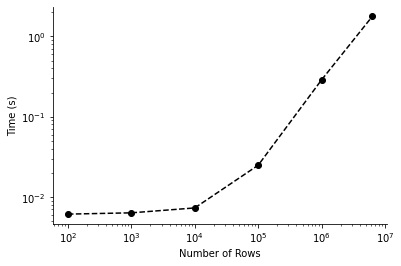

In [8]:
x, y = zip(*times)
plt.plot(x, y, 'ko--')
plt.ylabel('Time (s)')
plt.xlabel('Number of Rows')
plt.xscale('log')
plt.yscale('log')
sns.despine()

In [10]:
df_grouped['Prediction'] = df_grouped[1] > threshold

In [11]:
df_grouped.head()

,drug,llt,llt_id,0,1,Prediction
0,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,abdominal pain,35708154,0.000000,5.407278,True
1,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,ache,35843390,8.046981,0.000000,False
2,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,add,36978837,7.601817,0.000000,False
3,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,adverse reaction,35809321,8.079834,0.000000,False
4,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,agranulocytosis,35104874,0.000000,4.898713,True


In [12]:
predictions = df_grouped[df_grouped['Prediction']]
predictions.shape

(847008, 6)

In [13]:
df_grouped.shape

(1706791, 6)

In [19]:
predictions = predictions.rename(columns={'drug': 'xml_id', 'llt_id':'llt_concept_id'})
predictions.head()

,xml_id,llt,llt_concept_id,0,1,Prediction
0,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,abdominal pain,35708154,0.0,5.407278,True
4,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,agranulocytosis,35104874,0.0,4.898713,True
8,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,anaphylactic reaction,36009756,0.0,4.575467,True
9,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,anemia,35122651,0.0,4.466683,True
10,000e0356-cc97-4c3c-a0f7-57dcf0c52e30,angioedema,36009762,0.0,5.211185,True


## Check against those labels manually curated in reference panel

This is just to check we get the same/similar performance when going directly from 
the label downloaded from DailyMed rather than using the label xmls provided by the
Demmer-Fushman et al. Scientific Data paper. 

In [120]:
labelmap = pd.read_csv('../data/labels_to_xmlfiles_to_drugs.txt.gz', delimiter='|', header=None, names=['xml_id', 'zip_id', 'drug_id'])
labelmap.head()

,xml_id,zip_id,drug_id
0,ABD6ECF0-DC8E-41DE-89F2-1E36ED9D6535,20060131_ABD6ECF0-DC8E-41DE-89F2-1E36ED9D6535,ABD6ECF0-DC8E-41DE-89F2-1E36ED9D6535
1,dffb4544-0e47-40cd-9baa-d622075838cc,20060131_dffb4544-0e47-40cd-9baa-d622075838cc,dffb4544-0e47-40cd-9baa-d622075838cc
2,AAE8B7A4-742A-4BEC-A283-31B9408EE1AA,20060412_AAE8B7A4-742A-4BEC-A283-31B9408EE1AA,AAE8B7A4-742A-4BEC-A283-31B9408EE1AA
3,0AAAA03E-B258-45EC-89C8-06E1353F57EF,20060525_0AAAA03E-B258-45EC-89C8-06E1353F57EF,0AAAA03E-B258-45EC-89C8-06E1353F57EF
4,9C4F12E5-5E69-44D4-81A5-BD72C375EEF5,20060621_9C4F12E5-5E69-44D4-81A5-BD72C375EEF5,9C4F12E5-5E69-44D4-81A5-BD72C375EEF5


In [130]:
curated = pd.read_csv('../data/200_manual_annotations_csv/FinalReferenceStandard200Labels.csv', delimiter='|')
curated.tail()

,Index,Drug ID,Drug Name,Section LOINC,Section Display Name,MedDRA PT,PT ID,MedDRA LLT,LLT ID,Matching String,UMLS CUI,UMLS PrefName,Flag 1,Flag 2
14482,14483,fff5d805-4ffd-4e8e-8e63-6f129697563e,ZYKADIA,43685-7,WARNINGS AND PRECAUTIONS,Sudden death,10042434.0,Sudden death,10042434.0,sudden death,C0011071,Sudden death,NaN,NaN
14483,14484,fff5d805-4ffd-4e8e-8e63-6f129697563e,ZYKADIA,43685-7,WARNINGS AND PRECAUTIONS,Torsade de pointes,10044066.0,Torsade de pointes,10044066.0,torsade de pointes,C0040479,Torsades de Pointes,NaN,NaN
14484,14485,fff5d805-4ffd-4e8e-8e63-6f129697563e,ZYKADIA,43685-7,WARNINGS AND PRECAUTIONS,Transaminases increased,10054889.0,Transaminases increased,10054889.0,elevated transaminases,C0438717,Transaminases increased,NaN,NaN
14485,14486,fff5d805-4ffd-4e8e-8e63-6f129697563e,ZYKADIA,43685-7,WARNINGS AND PRECAUTIONS,Ventricular tachyarrhythmia,10065341.0,Ventricular tachyarrhythmia,10065341.0,ventricular tachyarrhythmias,C0042514,"Tachycardia, Ventricular",NaN,NaN
14486,14487,fff5d805-4ffd-4e8e-8e63-6f129697563e,ZYKADIA,43685-7,WARNINGS AND PRECAUTIONS,Vomiting,10047700.0,Vomiting,10047700.0,vomiting,C0042963,Vomiting,NaN,NaN


In [137]:
shared_drugs = set(curated[curated['Drug ID'].isin(labelmap['drug_id'])]['Drug ID'])

In [140]:
for drug in shared_drugs:
    if sum(labelmap['drug_id'] == drug) > 1:
        print(drug, sum(labelmap['drug_id'] == drug))

9333c79b-d487-4538-a9f0-71b91a02b287 2


In [139]:
labelmap[labelmap['drug_id']=='9333c79b-d487-4538-a9f0-71b91a02b287']

,xml_id,zip_id,drug_id
10873,ae16c72b-6d74-463c-b60c-8ef1d94840f3,20190111_9333c79b-d487-4538-a9f0-71b91a02b287,9333c79b-d487-4538-a9f0-71b91a02b287
44577,141f94df-19d2-459e-847e-c08f5064b937,20220329_9333c79b-d487-4538-a9f0-71b91a02b287,9333c79b-d487-4538-a9f0-71b91a02b287


In [149]:
df_inref = df_grouped[df_grouped['drug'].isin(labelmap[labelmap['drug_id'].isin(curated['Drug ID'])]['xml_id'])]
df_inref

,drug,llt,llt_id,0,1,Prediction
191885,1d10f043-1fbc-426c-969f-788b3a04e6f4,abdominal distension,35708151,0.000000,5.856255,True
191886,1d10f043-1fbc-426c-969f-788b3a04e6f4,abdominal pain,35708154,0.000000,4.898390,True
191887,1d10f043-1fbc-426c-969f-788b3a04e6f4,accommodation disorder,35607452,0.000000,4.325387,True
191888,1d10f043-1fbc-426c-969f-788b3a04e6f4,ache,35843390,6.985440,0.000000,False
191889,1d10f043-1fbc-426c-969f-788b3a04e6f4,acute pancreatitis,35736475,0.000000,5.446738,True
...,...,...,...,...,...,...
1696533,fe5bdab9-5b6e-4733-a962-c66b871db5af,trali,36256068,9.012747,0.000000,False
1696534,fe5bdab9-5b6e-4733-a962-c66b871db5af,tremor,36718265,0.000000,4.911359,True
1696535,fe5bdab9-5b6e-4733-a962-c66b871db5af,uti,36149143,8.820741,0.000000,False
1696536,fe5bdab9-5b6e-4733-a962-c66b871db5af,vomiting,35708208,0.000000,5.398830,True


In [168]:
xml_id = '1d10f043-1fbc-426c-969f-788b3a04e6f4'
'abdominal distension' in set(curated[curated['Drug ID'] == labelmap[labelmap['xml_id']==xml_id]['drug_id'].values[0]]['Matching String'])

labels = list()

for index, row in df_inref.iterrows():
    xml_id = row['drug']
    label_bool = row['llt'] in set(curated[curated['Drug ID'] == labelmap[labelmap['xml_id']==xml_id]['drug_id'].values[0]]['Matching String'])
    if label_bool:
        labels.append(1)
    else:
        labels.append(0)

len(labels), sum(labels)

(994, 329)

In [175]:
df_inref['Labels'] = labels

<ipython-input-175-a054965f386f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inref['Labels'] = labels


In [176]:
# This is consistent with the metrics we find when use the labels from the Demmer-Fushman paper 
# (note: only 9 examples here since we are working on just part of the data - NPT 4/15/22)
print(roc_auc_score(df_inref['Labels'], df_inref[1]))
print(metrics.f1_score(df_inref['Labels'], df_inref['Prediction']))

0.9227415042164682
0.8382749326145552
